<a href="https://colab.research.google.com/github/KirtiNayak11/ML/blob/main/GAN_DigitPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import Dense,LeakyReLU,Flatten
from tensorflow.keras import datasets

#Import and preprocess the DataSet

In [25]:
(xtrain,ytrain),(xtest,ytest)=datasets.mnist.load_data()

In [26]:
xtrain=xtrain/255

In [27]:
xtrain.shape

(60000, 28, 28)

In [28]:
xtrain=xtrain.reshape(xtrain.shape[0],28,28,1)

In [31]:
xtrain.shape

(60000, 28, 28, 1)

The from_tensor_slices method is a convenient way to create a dataset from an existing array or tensor. It takes a tensor as input and creates a dataset where each element of the tensor becomes an individual element in the dataset.
In this case, train_images is a NumPy array containing the training images. By passing train_images to from_tensor_slices, each image in the array becomes an individual element in the resulting dataset. This means that the dataset will consist of separate elements, each representing a single image from the training set.

In [32]:
xtrain_dataset=tf.data.Dataset.from_tensor_slices(xtrain)
xtrain_dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float64, name=None)>

In [34]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [ ]:
xtrain_dataset=xtrain_dataset.shuffle(BUFFER_SIZE)
xtrain_dataset=xtrain_dataset.batch(BATCH_SIZE)

#BUILD GENERATIVE MODEL

In [48]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


#The line noise = tf.random.normal([1, 100])
generates random noise using TensorFlow's tf.random.normal function. Let's break down the code:

tf.random.normal is a TensorFlow function that generates random numbers from a normal distribution.

The argument [1, 100] specifies the shape of the noise tensor to be generated. Here, it creates a tensor of shape (1, 100), meaning it has one row and 100 columns.

The shape (1, 100) indicates that the noise tensor has one instance of noise with 100 dimensions. In other words, it represents a single noise vector of length 100.

Each element in the noise tensor is sampled independently from a standard normal distribution (mean=0, standard deviation=1).

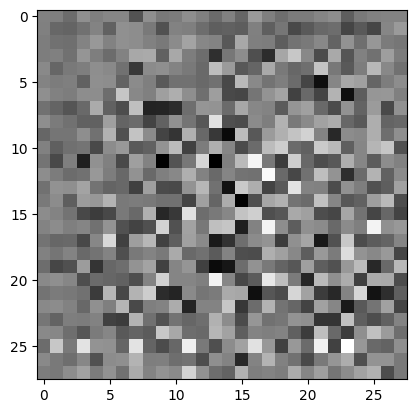

In [49]:
import matplotlib.pyplot as plt
dim=xtrain.shape

generator = make_generator_model()

noise = tf.random.normal([1, 100])

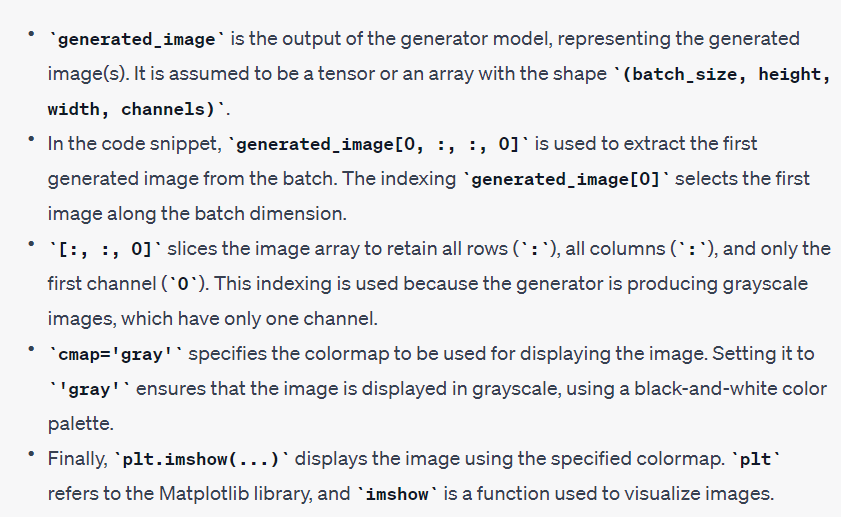

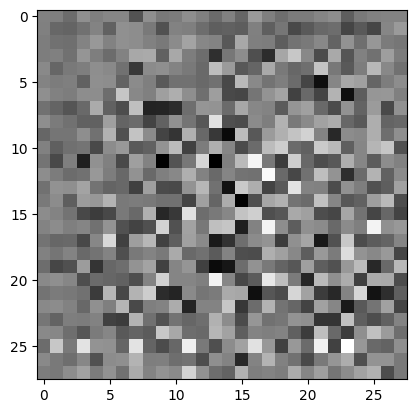

In [54]:
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#The Discriminator

In [50]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
     

In [51]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00084654]], shape=(1, 1), dtype=float32)


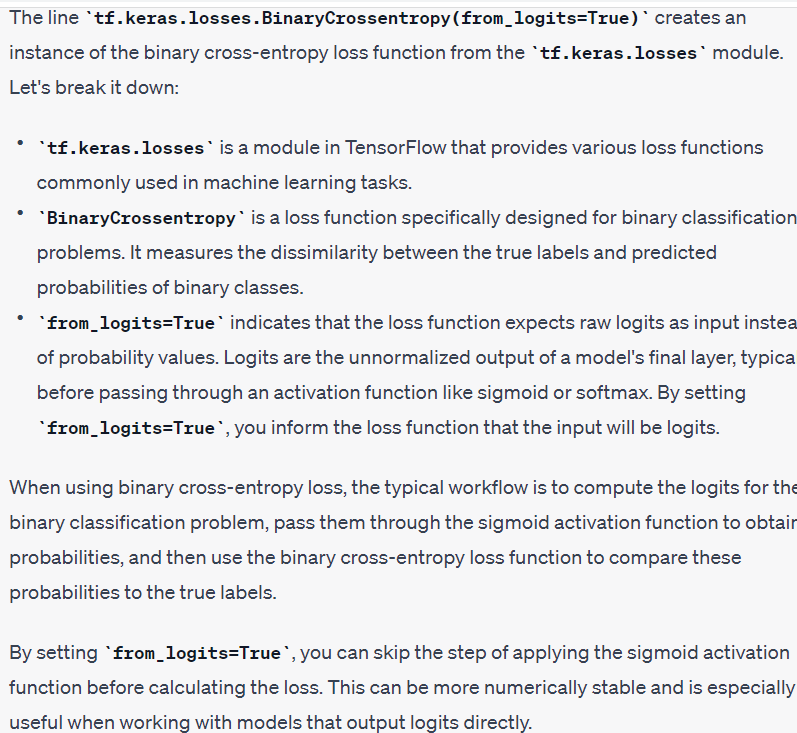

In [55]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

tf.ones_like is a TensorFlow function that creates a tensor filled with ones, with the same shape as the specified input tensor

tf.zeros_like is a TensorFlow function that creates a tensor filled with zeros, with the same shape as the specified input tensor.

In [56]:
from numpy import real
def discriminator_loss(real_output,fake_output):
    realLoss=cross_entropy(tf.ones_like(real_output,fake_output))
    fakeLoss=cross_entropy(tf.zeros_like(fake_output,real_output))
    totalLoss=realLoss+fakeLoss
    return totalLoss

In [57]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [58]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Training the loop

In [70]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
EPOCHS = 50
noise_dim = 100
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#Training the Model

In [60]:
def train(dataset,epochs):
      for epoch in range(epochs):

        for image_batch in dataset:
          train_step(image_batch)

In [ ]:
train(xtrain_dataset,5)